<h1 style="color:#f4fdff; background-color:#3772ff; padding: 10px; text-align: center; line-height: 1.5; border-radius: 10px;"> TEMPERED IMAGE DETECTION USING ERROR LEVEL ANALYSIS AND CONVOLUTIONAL NEURAL NETWORK </h1>

## 1.0 INTRODUCTION

This Jupyter Notebook serves as a part of the project titled "Hi-Witness; An ELA , Encrypted meta-data and CNN-based system for capturing and verifying eyewitness accounts". The aim of this notebook is to develope a neural network model using tensorflow to be able to identify whether an image has been tampered with or not. A convolutional nueral network model is trained on ELA images to achieve this objective.

<b> Error Level Analysis (ELA) </b>
Error Level Analysis is a technique used to identify areas of an image that have been modified or tampered with. It works based on the principle that when an image is compressed or edited, the error level introduced in the modified regions differs from the rest of the image. By extracting the difference in error levels into a new image which we will refer to as ELA image and using these images to train a CNN, we can identify if a image has potentially been tempered with.

<b> Convolutional Neural Networks (CNNs) </b>
Convolutional Neural Networks are a type of deep learning model commonly used for image analysis and classification tasks. CNNs are capable of learning complex patterns and features from images, making them well-suited for tampered image detection. By training a CNN on a large dataset of ELA images from both authentic and manipulated images, it can learn to distinguish between the two categories and make accurate predictions.


## 2.0 IMPORTING LIBRARIES

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from PIL import Image, ImageEnhance, ImageChops
import random
from shutil import copyfile
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle as pkl
import warnings
warnings.filterwarnings("ignore")

## 3.0 OVERVIEW DATASET 

The dataset for this project is the CASIA v2 Image tempering detection dataset which can be found <a href="https://www.kaggle.com/datasets/divg07/casia-20-image-tampering-detection-dataset"> here </a> on kaggle.  

The dataset contains 7492 Authentic images saved in the Au subfolder and 5125 Tempered images saved in the Tp subfolder. 

### 3.1 Distribution of Image formats in the dataset

In [3]:
def get_format_counts(path):
    ''' gets the counts of each image format in the specified path'''
    counts = {}

    for image in os.listdir(path):
        img_type = image.split('.')[-1]
        if img_type in counts:
            counts[img_type] += 1
        else:
            counts.update({img_type: 1})
    
    return counts

# Get the counts of formats in the authentic images folder
print(get_format_counts('/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au'))

# Get the counts of formats in the tempered images folder
print(get_format_counts('/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp'))

{'jpg': 7437, 'bmp': 54, 'db': 1}
{'jpg': 2064, 'tif': 3059, 'txt': 1, 'db': 1}



Based on the analysis of the image datasets, it has been determined that the authentic images dataset consists of 7,427 JPG images, while the remaining 55 files are considered unuseful for the current project. On the other hand, the tempered images dataset comprises 2,064 JPG images. However, the TIF format, although readable by the application, is also considered unuseful for this specific use case due to its lossless nature.

The decision to exclude TIF format images is based on the fact that the tampered image detection methodology utilized in this project relies heavily on the compression differences between original and resaved images. Since TIF format is lossless, it would pose challenges for the algorithm to effectively function when trained on such images.

As a result, the training and validation set for this project will consist of 7,427 images from the authentic set and 2,064 images from the tempered set. It is important to note that this distribution results in a highly imbalanced dataset.

### 3.2 Sample Authentic Images

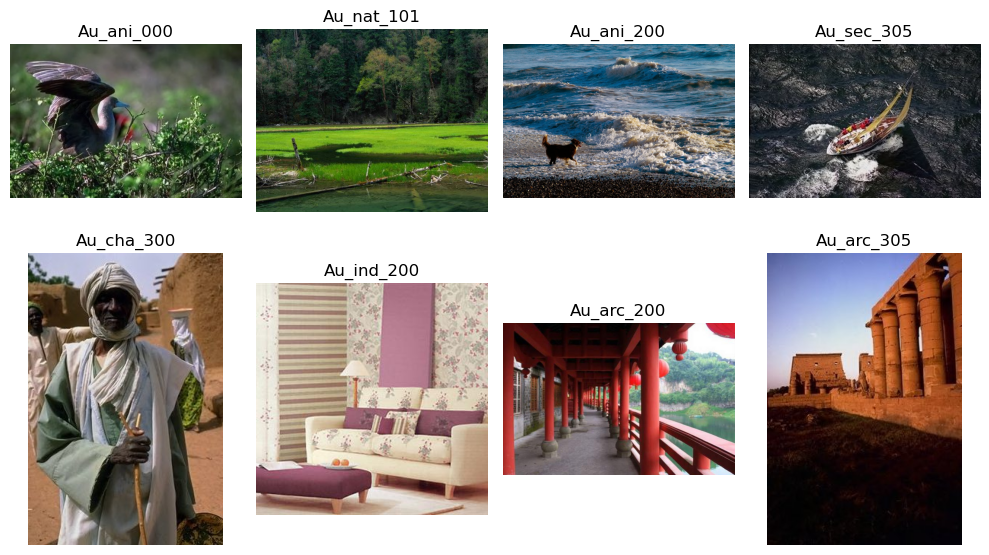

In [4]:
def show_images(path):
    # Get random 8 images from the path
    image_files = random.sample(os.listdir(path), 8)

    # Create a 2x4 grid of subplots
    fig, axes = plt.subplots(2, 4, figsize=(10, 6))

    # Iterate over the image files and plot them in the subplots
    for i, ax in enumerate(axes.flatten()):
        # Load and plot the image
        image_path = os.path.join(path, image_files[i])
        image = plt.imread(image_path)
        ax.imshow(image)
        ax.set_title(image_files[i][:10])  # Set the title as the image filename
        ax.axis('off')  # Turn off axis labels

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
    

# Path to the authentic images directory
image_dir = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au'
show_images(image_dir)

### 3.3 Sample Tempered Images

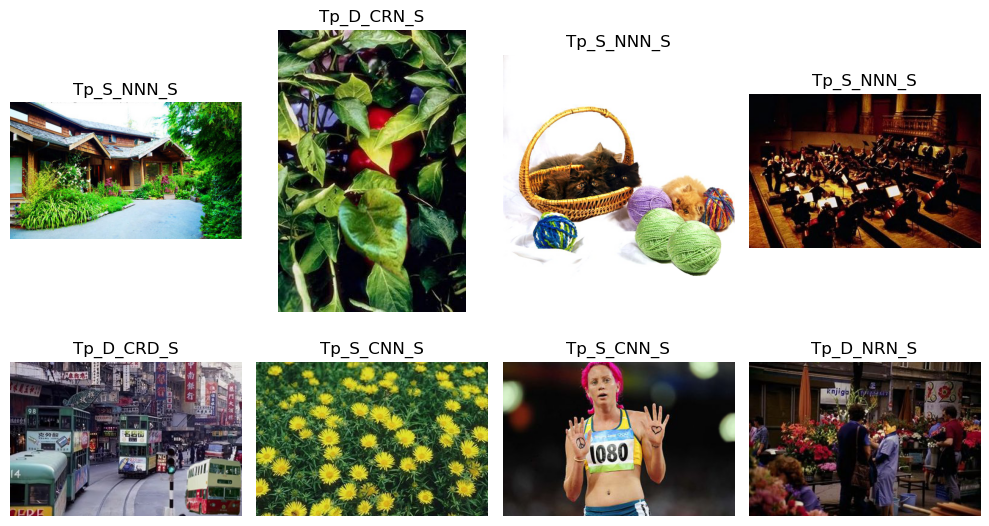

In [5]:
# Path to the authentic images directory
image_dir = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp'
show_images(image_dir)

## 4.0 CREATING ELA IMAGES FROM THE AUTHENTIC AND TEMPERED IMAGES

In this part, we create the ELA images from the authentic and tempered files into different folders. We ensure to filter out images which are not jpeg, jpg and png. 

In [6]:
def image_to_ela(path, quality, resave_path):
    ''' Gets images specified as path and resaves it at a new path resave_path at specified quality'''
    try:
        # Check if the file format is supported (JPEG or PNG)
        if path.endswith('jpg') or path.endswith('jpeg') or path.endswith('png'):
            # Open the image and convert it to RGB mode
            image = Image.open(path).convert('RGB')
            
            # Resave the image with the specified quality
            image.save('resaved.jpg', 'JPEG', quality=quality)
            resaved = Image.open('resaved.jpg')

            # Calculate the ELA (Error Level Analysis) image by taking the difference between the original and resaved image
            ela_image = ImageChops.difference(image, resaved)

            # Get the minimum and maximum pixel values in the ELA image
            band_values = ela_image.getextrema()
            max_value = max([val[1] for val in band_values])

            # If the maximum value is 0, set it to 1 to avoid division by zero
            if max_value == 0:
                max_value = 1

            # Scale the pixel values of the ELA image to the range [0, 255]
            scale = 255.0 / max_value
            ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

            # Save the ELA image with the same filename in the specified resave path
            ela_image.save(os.path.join(resave_path, os.path.basename(path)), 'JPEG')
    except Exception as e:
        print(f'Could not convert {path} to ELA: {str(e)}')


In [7]:
def preprocess_data(parent_path, files, resave_path):
    ''' Loops through a directory and applies the image_to_ela function to each image in the directory'''
    for file in files:
        image_to_ela(os.path.join(parent_path, file), 90, resave_path)

In [8]:
# get list of all authentic images
auth_files = os.listdir('/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au')

# get list of all Tempered images
doc_files = os.listdir('/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp')

# create the all_reals and all_docs where we save the real and doctored ELA images
os.mkdir('/kaggle/working/all_reals')
os.mkdir('/kaggle/working/all_Doc')

# converting  validation real images to ela
parent_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au'
preprocess_data(parent_path, auth_files, '/kaggle/working/all_reals')

# converting training doctored images to ela
parent_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp'
preprocess_data(parent_path, doc_files, '/kaggle/working/all_Doc')

print('There are ' + str(len(os.listdir('/kaggle/working/all_reals'))) + ' supported Authentic Images')
print('There are ' + str(len(os.listdir('/kaggle/working/all_Doc'))) + ' supported Tempered Images')

There are 7437 supported Authentic Images
There are 2064 supported Tempered Images


## 5.0 OVERVIEW OF THE ELA IMAGES

Lets look at the ELA images of the authentic images and Tempered images we plotted before. 

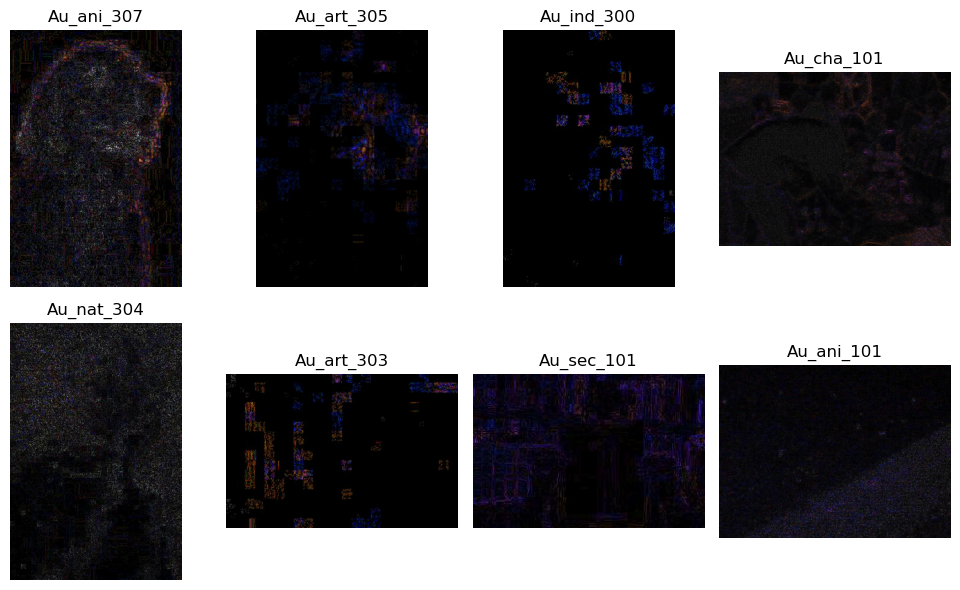

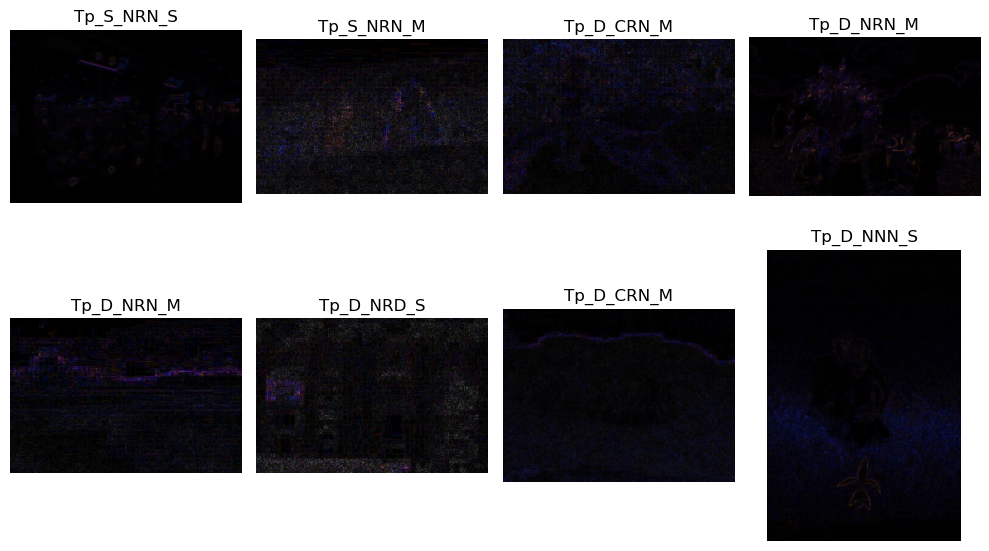

In [9]:
# Path to the authentic ela images directory
image_dir = '/kaggle/working/all_reals'
show_images(image_dir)

# Path to the tempered ela images directory
image_dir = '/kaggle/working/all_Doc'
show_images(image_dir)

## 6.0 SPLITTING THE ELA IMAGES INTO TRAINING AND VALIDATION SETS

The Convolutional Neural network models will be trained on images streamed from directory using the inbuilt tensorflow ImageGenerator. The ImageGenerator automatically labels images in a subdirectories using the directory name. To leverage the automatic labeling functionality of ImageDataGenerator, you need to adhere to a specific directory structure. Here's a breakdown of the required format:

- Training Data Directory:

This directory serves as the main directory for the training dataset.
Inside the training data directory, We would create subdirectories that correspond to the classes or categories we want to classify.
For example, since we are interested in Real and Doctored classifcations, we create two subdirectories named "Real" and "Doctored" within the training data directory.
All images belonging to the "Real" class would be placed in the "Real" subdirectory, while all images belonging to the "Doctored" class would be placed in the "Doctored" subdirectory.

- Validation Data Directory

Similar to the training data directory, the validation data directory serves as a separate directory for the validation dataset.
It should mirror the structure of the training data directory, with subdirectories corresponding to each class.
Images for validation should be placed in their respective class subdirectories within the validation data directory.

By organizing your data in this manner, the ImageDataGenerator will automatically assign labels to the images based on the subdirectory names.This structured organization simplifies image management, labeling, and seamlessly integrates with the ImageDataGenerator during CNN training.

In [10]:
# creating the parent directory for both the Training and Validation datasets
ela_path = os.path.join(os.getcwd(), 'ela_images')

# create path for training set and the different labels
auth_path_train = os.path.join(ela_path, 'train',  'Real')
temp_path_train = os.path.join(ela_path, 'train', 'Doctored')
os.makedirs(auth_path_train)
os.makedirs(temp_path_train)

# create path for validation set and its different labels
auth_path_val = os.path.join(ela_path, 'Val',  'Real')
temp_path_val = os.path.join(ela_path, 'Val', 'Doctored')
os.makedirs(auth_path_val)
os.makedirs(temp_path_val)

In [11]:
# Get the list of files in the 'all_reals' directory
real_files = os.listdir('/kaggle/working/all_reals')

# Get the list of files in the 'all_Doc' directory
doc_files = os.listdir('/kaggle/working/all_Doc')

# Calculate the total length for training and validation sets for doctored images
total_len_train_doc = int((90 / 100) * len(doc_files))
total_len_val_doc = int((10 / 100) * len(doc_files))

# Randomly select files for validation from the authentic image files
val_auth = random.choices(real_files, k=total_len_val_doc)

# Select the remaining files for training from the authentic image files
train_auth = [f for f in real_files if f not in val_auth][:total_len_train_doc]

# Randomly select files for validation from the doctored image files
val_doc = random.choices(doc_files, k=total_len_val_doc)

# Select the remaining files for training from the doctored image files
train_doc = [f for f in doc_files if f not in val_doc][:total_len_train_doc]

# Path to the destination directories for training and validation authentic images
auth_path_train = '/kaggle/working/ela_images/train/Real'
auth_path_val = '/kaggle/working/ela_images/Val/Real'

# Path to the destination directories for training and validation doctored images
temp_path_train = '/kaggle/working/ela_images/train/Doctored'
temp_path_val = '/kaggle/working/ela_images/Val/Doctored'

# Copy the training authentic images to ela_images/train/Real
for item in train_auth:
    copyfile('/kaggle/working/all_reals/{}'.format(item), "{}/{}".format(auth_path_train, os.path.basename(item)))

# Copy the validation authentic images to ela_images/Val/Real
for item in val_auth:
    copyfile('/kaggle/working/all_reals/{}'.format(item), "{}/{}".format(auth_path_val, os.path.basename(item)))

# Copy the training doctored images to ela_images/train/Doctored
for item in train_doc:
    copyfile('/kaggle/working/all_Doc/{}'.format(item), "{}/{}".format(temp_path_train, os.path.basename(item)))

# Copy the validation doctored images to ela_images/Val/Doctored
for item in val_doc:
    copyfile('/kaggle/working/all_Doc/{}'.format(item), "{}/{}".format(temp_path_val, os.path.basename(item)))

# Print the lengths of the validation and training sets for authentic and doctored images
print("There are a total of " + str(len(train_auth)) + "Authentic Images in the training set")
print("There are a total of " + str(len(train_doc)) + "Doctored Images in the training set")
print("There are a total of " + str(len(val_auth)) + "Authentic Images in the Validation set")
print("There are a total of " + str(len(val_doc)) + "Doctored Images in the Validation set")


There are a total of 1857Authentic Images in the training set
There are a total of 1857Doctored Images in the training set
There are a total of 206Authentic Images in the Validation set
There are a total of 206Doctored Images in the Validation set


## 7.0 CREATE IMAGE GENERATORS FOR STREAMING IMAGES TRAINING AND VALIDATION DATA

We pass the path to the trainning and validation dataset directory to the ImageDataGenerator object to create two respective image data generators. We also specify the size of the streamed images to be 150 x 150 and in batch size of 8.

In [17]:
# Create an instance of the ImageDataGenerator
datagen = ImageDataGenerator()

# Generate training images
train_images = datagen.flow_from_directory(
    '/kaggle/working/ela_images/train',
    target_size=(150, 150),
    batch_size=8,
    class_mode='binary'
)

# Generate validation images
validation_images = datagen.flow_from_directory(
    '/kaggle/working/ela_images/Val',
    target_size=(150, 150),
    batch_size=8,
    class_mode='binary'
)

Found 3714 images belonging to 2 classes.
Found 399 images belonging to 2 classes.


## 8.0. THE NETWORK ARCHITECTURE

In [18]:
def train_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (150, 150, 3)),
        tf.keras.layers.Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu'),
        tf.keras.layers.MaxPool2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(150, activation = 'relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])
    
    return model

In [19]:
model = train_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 146, 146, 32)      2432      
                                                                 
 conv2d_3 (Conv2D)           (None, 142, 142, 32)      25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 71, 71, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 71, 71, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 161312)            0         
                                                                 
 dense_2 (Dense)             (None, 150)               24196950  
                                                      

In [20]:

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', Precision(), Recall()]
)

In [21]:
history = model.fit(
    train_images,  
    steps_per_epoch=len(train_images) / 8,
    epochs=30,
    validation_data = validation_images
)

Epoch 1/30
58/58 [==============================] - 58s 977ms/step - loss: 11.5260 - accuracy: 0.6123 - precision_1: 0.5876 - recall_1: 0.6970 - val_loss: 1.8180 - val_accuracy: 0.6717 - val_precision_1: 0.6129 - val_recall_1: 0.9453
Epoch 2/30
58/58 [==============================] - 56s 969ms/step - loss: 0.6327 - accuracy: 0.8114 - precision_1: 0.8185 - recall_1: 0.8219 - val_loss: 0.4210 - val_accuracy: 0.8246 - val_precision_1: 0.7964 - val_recall_1: 0.8756
Epoch 3/30
58/58 [==============================] - 56s 969ms/step - loss: 0.4538 - accuracy: 0.8199 - precision_1: 0.8194 - recall_1: 0.8087 - val_loss: 0.3742 - val_accuracy: 0.8521 - val_precision_1: 0.8698 - val_recall_1: 0.8308
Epoch 4/30
58/58 [==============================] - 56s 969ms/step - loss: 0.4500 - accuracy: 0.8220 - precision_1: 0.8584 - recall_1: 0.7801 - val_loss: 0.4045 - val_accuracy: 0.8195 - val_precision_1: 0.7792 - val_recall_1: 0.8955
Epoch 5/30
58/58 [==============================] - 60s 1s/step - l

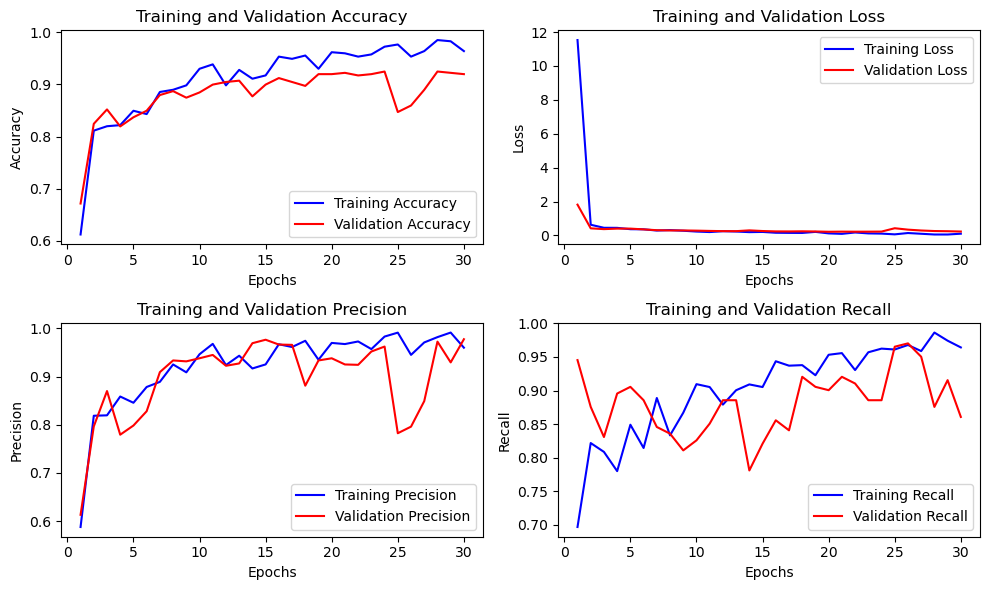

In [23]:
def plot_accuracy(history):
    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
        
    # Get the training and validation accuracy values from the history object
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Get the training and validation loss values from the history object
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Get the training and validation precision values from the history object
    train_precision = history.history['precision_1']
    val_precision = history.history['val_precision_1']
    
    # Get the training and validation recall values from the history object
    train_recall = history.history['recall_1']
    val_recall = history.history['val_recall_1']
    
    # Get the number of epochs
    epochs = range(1, len(train_acc) + 1)
    
    # Plot the training and validation accuracy
    axes[0, 0].plot(epochs, train_acc, 'b', label='Training Accuracy')
    axes[0, 0].plot(epochs, val_acc, 'r', label='Validation Accuracy')
    axes[0, 0].set_title('Training and Validation Accuracy')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    
    # Plot the training and validation loss
    axes[0, 1].plot(epochs, train_loss, 'b', label='Training Loss')
    axes[0, 1].plot(epochs, val_loss, 'r', label='Validation Loss')
    axes[0, 1].set_title('Training and Validation Loss')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    
    # Plot the training and validation precision
    axes[1, 0].plot(epochs, train_precision, 'b', label='Training Precision')
    axes[1, 0].plot(epochs, val_precision, 'r', label='Validation Precision')
    axes[1, 0].set_title('Training and Validation Precision')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    
    # Plot the training and validation recall
    axes[1, 1].plot(epochs, train_recall, 'b', label='Training Recall')
    axes[1, 1].plot(epochs, val_recall, 'r', label='Validation Recall')
    axes[1, 1].set_title('Training and Validation Recall')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    
    # Adjust the layout
    fig.tight_layout()
    
    # Show the plot
    plt.show()


plot_accuracy(history)


For our applicaton usecase, We would want the application to perform equally great at both precision and recall. We would want it to attempt to identify all the tempered images while still reducing the errors of classifying authentic images as tempered. Hence, accuracy is a great metric for us. From the training we are able to achieve an accuracy of between 96 and 98% on training dataset and between 90 and 92% on test dataset.

## 9.0 SAVE THE MODEL

In [ ]:
model.save('model.h5')